## Importing Libraries 

Notice: The code works for tensorflow version 1.2.1 as higher order gradients are implemented. We implement all the models on K80 and we highly recommend using a GPU.

In [1]:
import copy
from influence_utils import *
import numpy as np
import tensorflow as tf
from influence import Influence, plot_mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras import applications
from scipy.stats import spearmanr
from PIL import Image

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

Using TensorFlow backend.


## Retrain the Final Layers of Inception v3 Model on Flowers Dataset

For the influence function attacks, we used a pretrained inception model, and retrained it on a new two-class task, just like the original authors (see [the original paper](https://arxiv.org/pdf/1703.04730.pdf) for more details). The new images were of two kinds of flowers: sunflower and roses. You can obtain the images at [this location](http://download.tensorflow.org/example_images/flower_photos.tgz), or use a different set of images with this notebook.

In [2]:
session_parameters = retrain_inception_on_flowers(new_training_data=True) #retrain the network and save certain session parameters
graph, sess, W_flat, cross_entropy, X, y, y_, train_data, train_labels, train_shuffle_idx, valid_shuffle_idx = session_parameters

Regenerating training data: 0
Regenerating training data: 100
Regenerating training data: 200
Regenerating training data: 300
Regenerating training data: 400
Regenerating training data: 500
Regenerating training data: 600
Regenerating training data: 700
Regenerating training data: 800
Regenerating training data: 900
Regenerating validation data: 0
Regenerating validation data: 100
Epoch 0, Batch Acc=0.9
Test Accuracy: 0.9
Epoch 1, Batch Acc=0.92
Test Accuracy: 0.965
Epoch 2, Batch Acc=0.93
Test Accuracy: 0.955
Epoch 3, Batch Acc=0.95
Test Accuracy: 0.96
Epoch 4, Batch Acc=0.94
Test Accuracy: 0.96
Epoch 5, Batch Acc=0.95
Test Accuracy: 0.96
Epoch 6, Batch Acc=0.96
Test Accuracy: 0.965
Epoch 7, Batch Acc=0.97
Test Accuracy: 0.965
Epoch 8, Batch Acc=0.97
Test Accuracy: 0.97
Epoch 9, Batch Acc=0.97
Test Accuracy: 0.97


## Let's Try Influence Functions on a Training Example

We expect influence functions to identify the same training example as having the most influence on the training example's prediction. Note: Our implementation of influence functions computes the inverse Hessian vector products (IHVP) exactly. While this is not necessarily needed for the gradient-based attack, we found that the results of the original influence functions were improved when the IHVP was computed exactly, as opposed to using numerical approximations. This may require significant memory. For our network, we found that a K80 had sufficient memory to run this algorithm when all other python processes were closed.

In [3]:
il = ImageLoader() #a general class for loading and displaying iamges

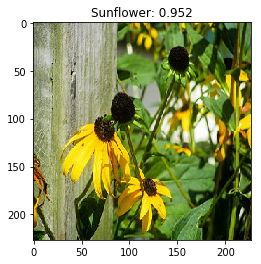

In [4]:
image_index = 0 #which training image
pic, feature = il.load_candidate_image(train_shuffle_idx[0], img_folder='train', dataset='flowers', model='Inception')
prob, label_idx = make_prediction(sess, X, y, feature)
plt.imshow(pic)
labels = ['Rose','Sunflower']; label = labels[label_idx]
plt.title(label + ': ' + str(np.round(prob[0][0],3)))

In [5]:
infl = Influence(graph, sess, [W_flat], cross_entropy, X, y_, train_data, train_labels)

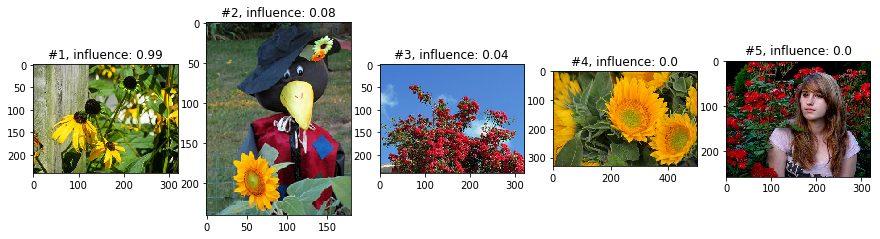

In [6]:
influences = infl.compute_exact_influence(train_data[0], train_labels[0], damping=0)
show_influential_images(infl, train_shuffle_idx, valid_shuffle_idx, dataset='flowers', middle=False, bottom=False, model='Inception')

## Now Let's Use Our Gradient-Based Attack on a Test Example 

The attack we use is a simple, one-step gradient-based attack that simply tries to decrease the influence of the top three most influential training images for a given test image by perturbing the test image by an imperceptible change. We find that this attack effectively reduces the influences of those three images, and usually other training images as well.

In [7]:
damping = 0
filenames_train = np.load('data/flower_photos/filenames_train-inception.npy')    
filenames_validation = np.load('data/flower_photos/filenames_validation-inception.npy')    
img_width, img_height = 227, 227
root_path = 'data/flower_photos/'
img_folder = 'train'

#This method takes the feature representation and calculates how it needs to change to
#the influence for the particular training_image by a particular factor.
def update_feature_to_increase_influence(feature, training_image, factor, verbose=False):
    influence_before = infl.compute_exact_influence(feature, np.array([label_idx]), damping=damping, idx_train=training_image)
    grads = infl.gradient_ascent_on_influence(feature, np.array([label_idx]), damping=damping, idx_train=training_image)
    signed_grad = np.sign(grads)
    feature = feature + factor*signed_grad
    influences = infl.compute_exact_influence(feature, np.array([label_idx]), damping=damping)
    return feature

Here we define a helper function to produce figures for the paper

In [8]:
#idx is the index of the validation image
#This method suppresses the influence of the top 3, and upraises of the next 3
def find_gradient_and_makeplot(idx, verbose=False):
    pic0, feature0 = il.load_candidate_image(valid_shuffle_idx[idx], img_folder='validation', dataset='flowers', model='Inception')
    prob, label_idx = make_prediction(sess, X, y, feature0)
    label_str0 = labels[label_idx]
    predictions0 = compute_confidence_from_probability(prob, label_idx)
    influences_baseline = infl.compute_exact_influence(feature0, np.array([label_idx]), damping=damping)
    infl0 = copy.copy(infl)
    most0, values0 = infl.get_most_neutral_least(return_influence_values_for_most=True,N=5)
    
    top3 = np.argsort(influences_baseline)[-3:]
    new_feature = feature0.copy() #needed
    for i in top3:
        new_feature = update_feature_to_increase_influence(new_feature, i, -0.01)
    
    feature_grad = new_feature-feature0
    feature_grad = feature_grad.reshape(2048)
    input_grads = il.pgti(feature_grad, pic0)
    input_grads = input_grads[0]
            
    noises = np.array([8])/255
    N_TRIALS = 1; i=0; N_NOISES = len(noises)

    predictions = np.zeros((N_TRIALS, N_NOISES))
    influence_correlation = np.zeros((N_TRIALS, N_NOISES))
    top5 = np.zeros((N_TRIALS, N_NOISES))

    for j, noise in enumerate(noises):
        pic = np.minimum(np.maximum(pic0 + noise*np.sign(input_grads),0),1)
        feature = il.get_bottleneck_representation(pic)
        
        pic = pic.reshape((227,227,3))
        prob, label_idx = make_prediction(sess, X, y, feature)
        label_str = labels[label_idx]

        influences = infl.compute_exact_influence(feature, np.array([label_idx]), damping=damping)
        most, values = infl.get_most_neutral_least(return_influence_values_for_most=True,N=5)

        prediction = compute_confidence_from_probability(prob, label_idx)
        predictions[i,j] = prediction
        correlation = spearmanr(influences_baseline, influences)[0]
        influence_correlation[i,j] = correlation
        top5[i,j] = len(set(most0)) - len(set(most0) - set(most)) #the number of elements of most0 that are in most

    plt.figure(figsize=[12,4])
    plt.subplots_adjust(wspace=0)
    plt.rc("font",family="sans-serif")
    plt.rcParams["font.sans-serif"] = "Arial"

    n_rows = 2; n_cols = 6
    
    # Plot the original image
    ax1 = plt.subplot2grid((n_rows, n_cols), (0, 0), colspan=1, rowspan=1)
    ax1.imshow(pic0)
    title = "'"+label_str0+"': " + str(np.round(100*predictions0,1))+'% conf.'
    ax1.set_title(title)
    ax1.axis('off')

    rect = patches.Rectangle((0,0),227,227,linewidth=4,edgecolor='r',facecolor='none')
    ax1.add_patch(rect)

    # Plot the most influential training images
    for j in range(3):
        ax2 = plt.subplot2grid((n_rows, n_cols), (0, j+1), colspan=1, rowspan=1)

        true_idx = train_shuffle_idx[most0[-j-1]]
        filename = filenames_train[true_idx]
        pic = Image.open(root_path+img_folder+"/"+filename)
        pic = pic.resize((img_width, img_height))
        ax2.imshow(np.array(pic))
        ax2.axis('off')
        ax2.set_title('#' + str(j+1) + ', Influence: '+str(np.round(values0[-j-1],2)))

    # Plot the perturbed test image
    ax1 = plt.subplot2grid((n_rows, n_cols), (1, 0), colspan=1, rowspan=1)
    ax1.imshow(pic0)
    title = "'"+label_str+"': " + str(np.round(100*prediction,1))+'% conf.'
    ax1.set_title(title)
    ax1.axis('off')

    rect = patches.Rectangle((0,0),227,227,linewidth=4,edgecolor='r',facecolor='none')
    ax1.add_patch(rect)

    # Plot the new most influential training images
    for j in range(3):
        ax2 = plt.subplot2grid((n_rows, n_cols), (1, j+1), colspan=1, rowspan=1)

        true_idx = train_shuffle_idx[most[-j-1]]
        filename = filenames_train[true_idx]
        pic = Image.open(root_path+img_folder+"/"+filename)
        pic = pic.resize((img_width, img_height))
        ax2.imshow(np.array(pic))
        ax2.axis('off')
        ax2.set_title('#' + str(j+1) + ', Influence: '+str(np.round(values[-j-1],2)))

                
    # Plot influences against each other
    ax5 = plt.subplot2grid((n_rows, n_cols), (0, 4), colspan=2, rowspan=2)
    ax5.plot(influences_baseline, influences, 'o', )
    lims = [
        np.min([ax5.get_xlim(), ax5.get_ylim()]),  # min of both axes
        np.max([ax5.get_xlim(), ax5.get_ylim()]),  # max of both axes
    ]
    ax5.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label=r'$R_s =$ '+str(np.round(correlation, 2)))
    ax5.set_aspect('equal')
    ax5.set_xlim(lims)
    ax5.set_ylim(lims)
    ax5.set_xlabel('Original Influence', fontsize=14)
    ax5.set_ylabel('Perturbed Influence', fontsize=14)
    plt.legend(loc='upper left', prop={'size': 14}, numpoints=1, framealpha=0.5)

    plt.tight_layout(w_pad=0)
    plt.show()

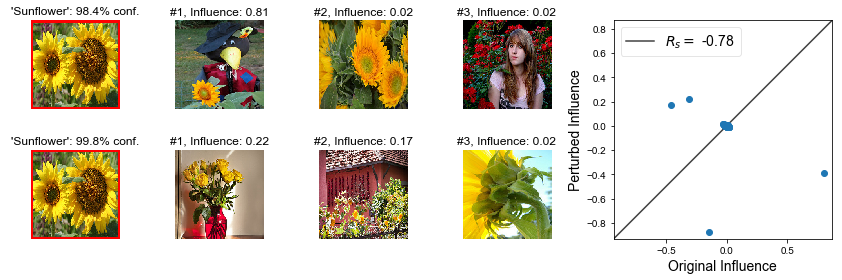

In [12]:
find_gradient_and_makeplot(4, verbose=False)